## Variational Autoencoders on MNIST Dataset

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

In [2]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = n_to_predict = 5000

In [3]:
# Load dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

## Load pretrained variational autoencoder model

To train model, use `train.py` file.

In [4]:
VAE = torch.load("vae_mnist.pth")
VAE.to(device)

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (z_mean): Linear(in_features=2048, out_features=2, bias=True)
    (z_log_var): Linear(in_features=2048, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=2, out_features=2048, bias=True)
    (unflatten): Unflatten(dim=1, unflattened_size=(128, 4, 4))
    (deconv1): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (deconv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (deconv3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (output): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 

## Reconstruct using the VAE

In [5]:
example_images, example_labels = next(iter(test_loader))
predictions, _, _ = VAE(example_images.to(device))

Example real digit Image


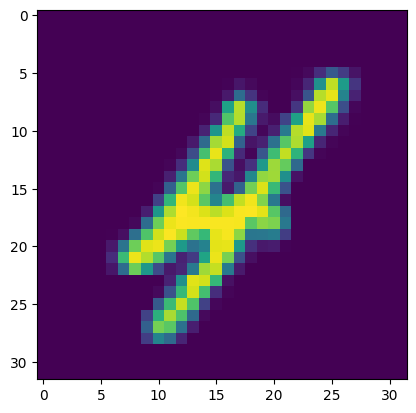

Reconstructed Image


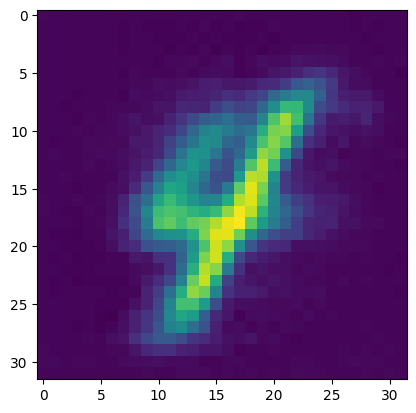

In [6]:
print("Example real digit Image")
plt.imshow(example_images[10].cpu().numpy().transpose(1, 2, 0))
plt.show()

print("Reconstructed Image")
plt.imshow(predictions[10].detach().cpu().numpy().transpose(1, 2, 0))
plt.show()

## Feature Embedding using the Encoder 

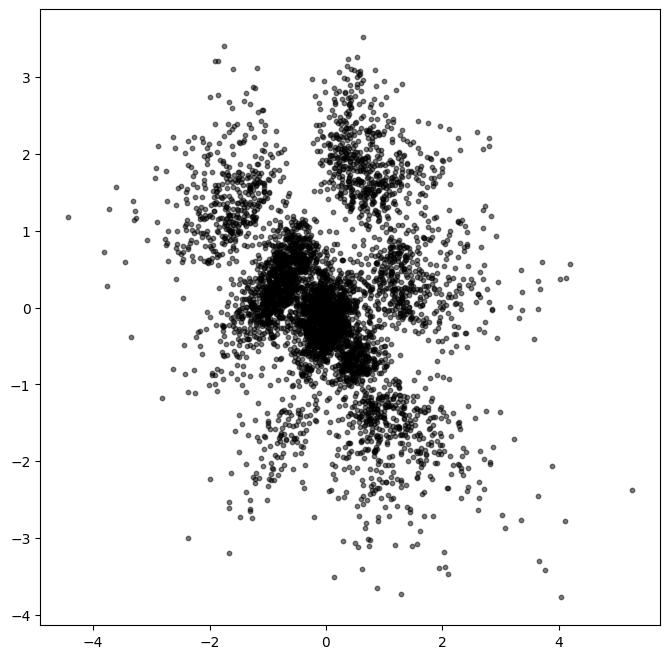

In [7]:
encoder = VAE.encoder
embeddings, _, _ = encoder(example_images.to(device))

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0].detach().cpu().numpy(), embeddings[:, 1].detach().cpu().numpy(), c="black", alpha=0.5, s=10)
plt.show()

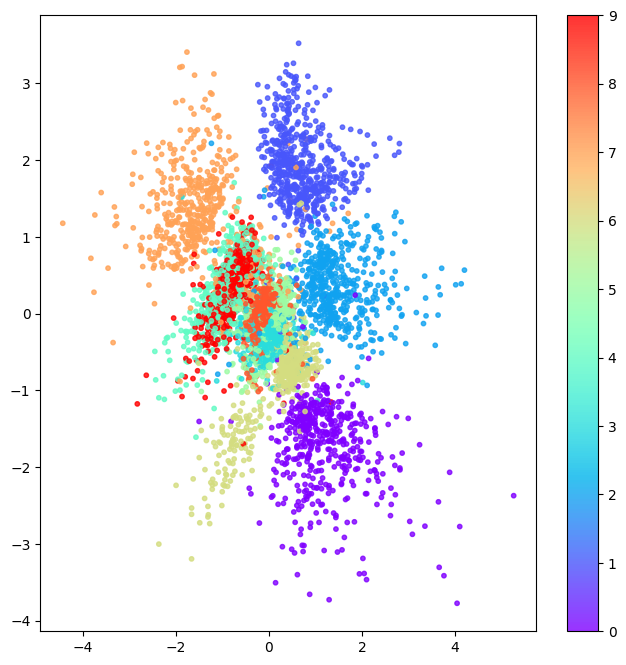

In [8]:
example_labels = example_labels[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0].detach().cpu().numpy(), embeddings[:, 1].detach().cpu().numpy(), cmap="rainbow", c=example_labels, alpha=0.8, s=10)
plt.colorbar()
plt.show()

## Generate using the decoder 

In [9]:
# Sample some points in the latent space
grid_width, grid_height = (6, 3)
sample = np.random.uniform(size=(grid_width * grid_height, 2))

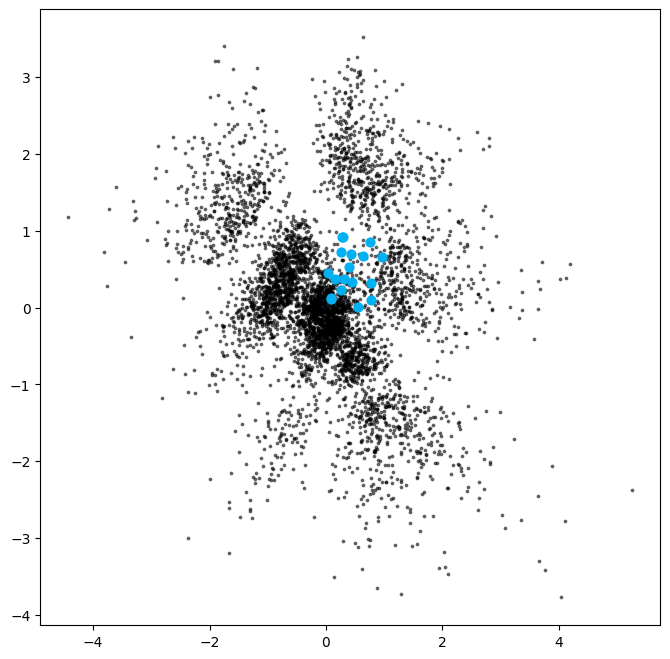

In [10]:

# Decode the sampled points
reconstructions = VAE.decoder(torch.Tensor(sample).to(device))

# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(embeddings.detach().cpu().numpy())
p_sample = norm.cdf(sample)

# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0].detach().cpu().numpy(), embeddings[:, 1].detach().cpu().numpy(), c="black", alpha=0.5, s=3)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

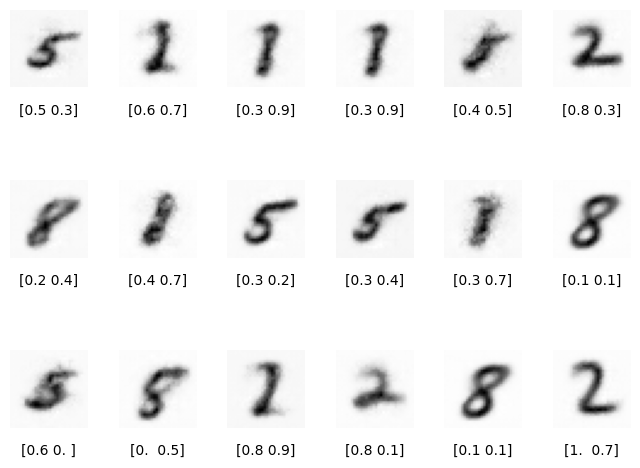

In [11]:
# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(0.5, -0.35, str(np.round(sample[i, :], 1)), fontsize=10, ha="center", transform=ax.transAxes)
    ax.imshow(reconstructions[i, 0].cpu().detach().numpy(), cmap="Greys")


### Exploring the latent space

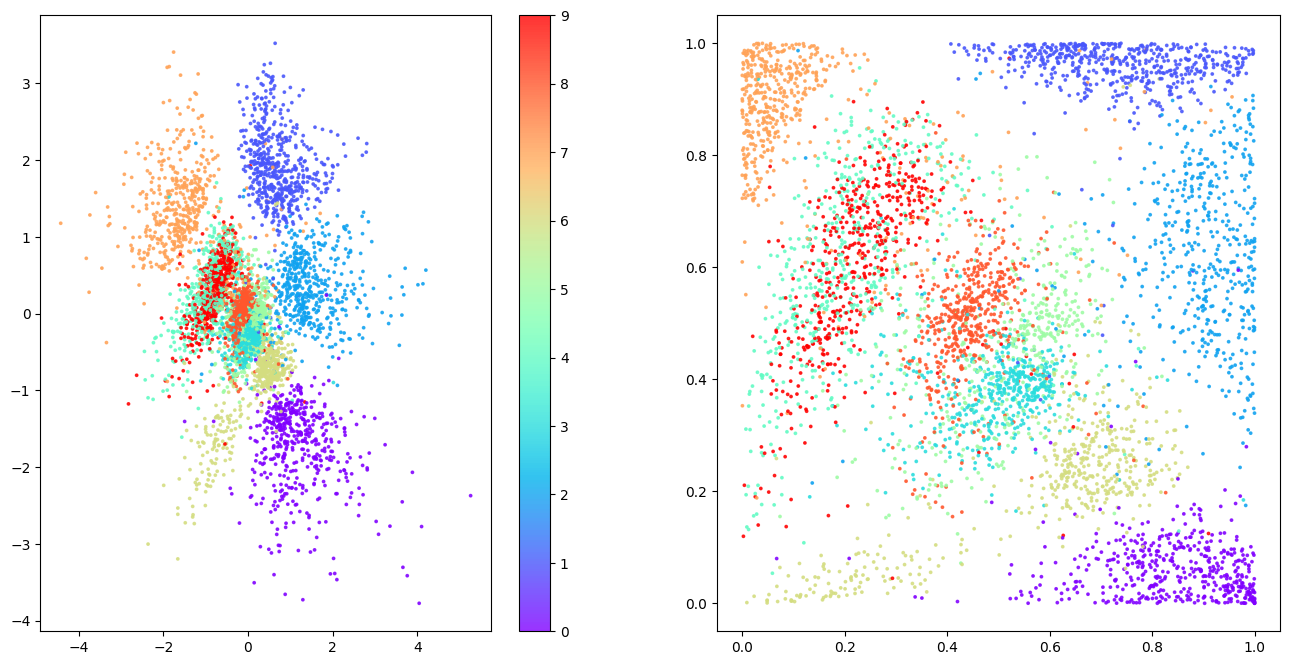

In [12]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(embeddings[:, 0].detach().cpu().numpy(), embeddings[:, 1].detach().cpu().numpy(), cmap="rainbow", c=example_labels, alpha=0.8, s=3)
plt.colorbar(plot_1)

ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3)
plt.show()


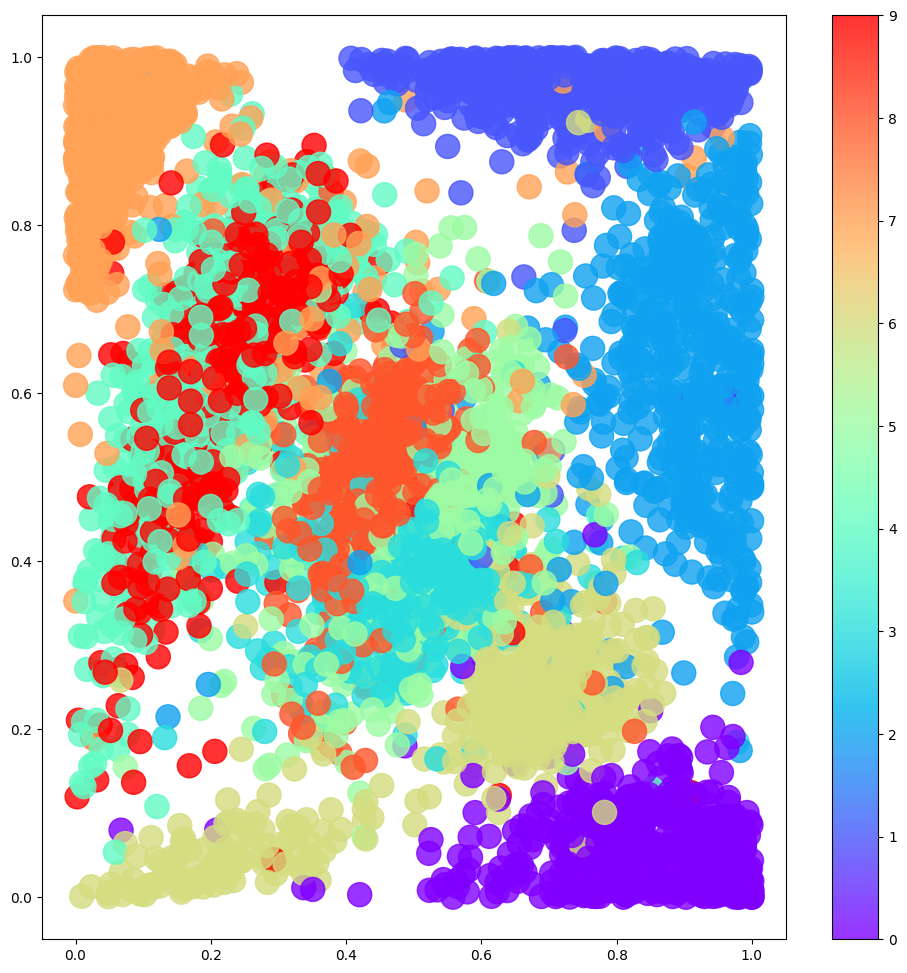

In [13]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300)
plt.colorbar()

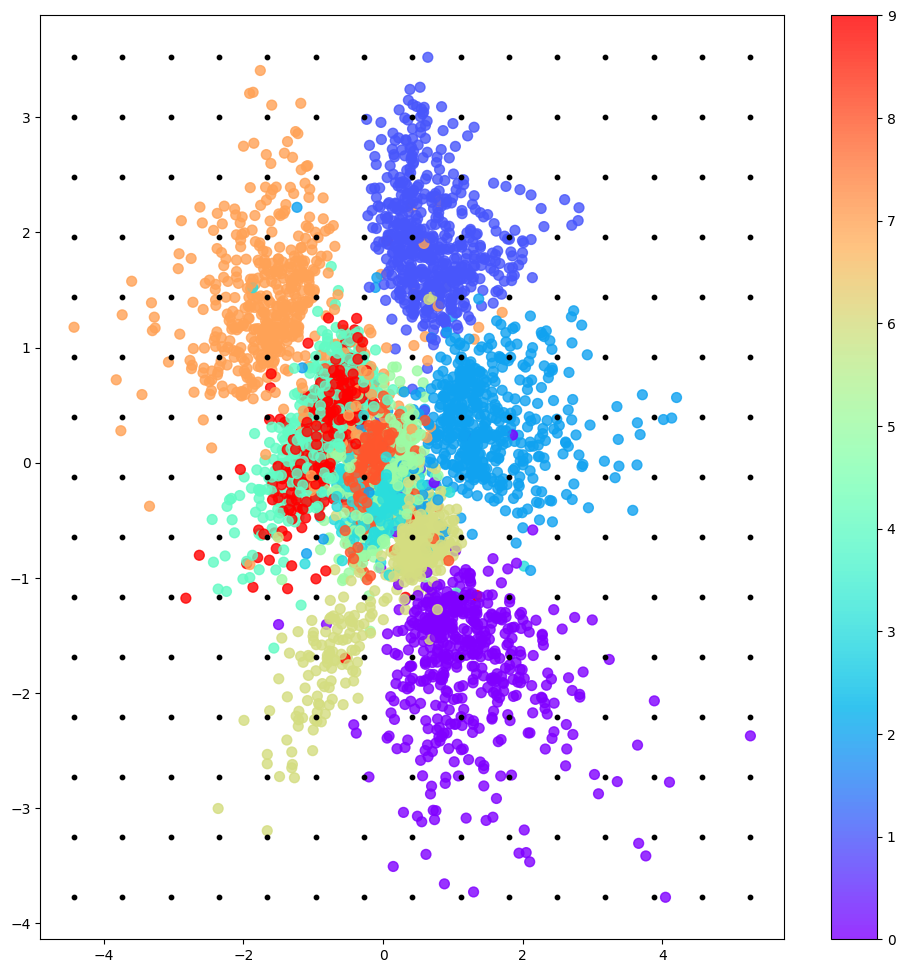

In [14]:

# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0].detach().cpu().numpy(), embeddings[:, 1].detach().cpu().numpy(), cmap="rainbow", c=example_labels, alpha=0.8, s=50)
plt.colorbar()

x = np.linspace(min(embeddings[:, 0].detach().cpu().numpy()), max(embeddings[:, 0].detach().cpu().numpy()), grid_size)
y = np.linspace(max(embeddings[:, 1].detach().cpu().numpy()), min(embeddings[:, 1].detach().cpu().numpy()), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = VAE.decoder(torch.Tensor(grid).to(device))
plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()


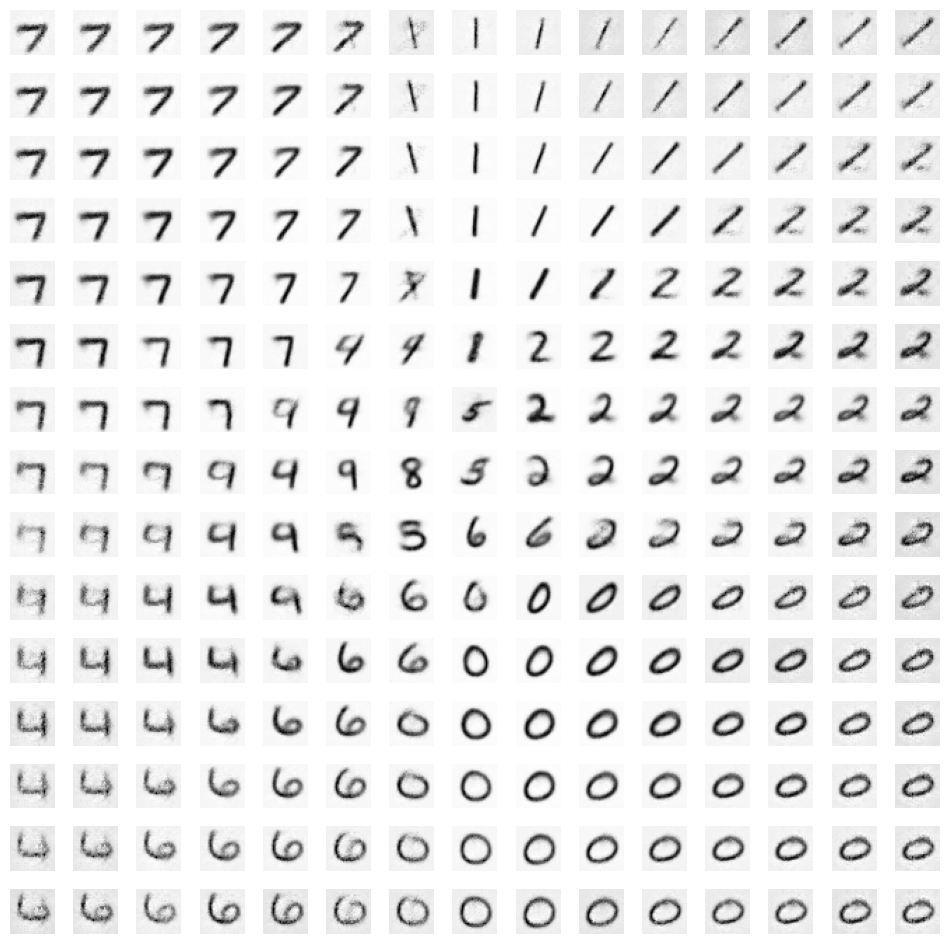

In [15]:

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, 0].cpu().detach().numpy(), cmap="Greys")
plt.show()